## 1. Load dataset

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import cvxpy as cp
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import KernelPCA


In [278]:
# Load UCI Digits dataset
digits = datasets.load_digits()
X, y = digits.data, digits.target
X = X[:100]

print(X.shape)


(100, 64)


In [279]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate two-moon datasets
graph_number = 10
single_view_graph_X = []
for i in range(graph_number):
    X, y = make_moons(n_samples=100, noise=0.05, random_state=i+10)
    single_view_graph_X.append(X)

## 2. Algorithm

### 2.1 Single View Graph Learning

In [280]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.optimize import nnls
from sklearn import datasets
from tqdm import tqdm 

def estimate_sigma(X):
    pairwise_dists = np.linalg.norm(X[:, np.newaxis] - X, axis=2)  # Compute pairwise L2 distances
    sigma = np.median(pairwise_dists)  # Use the median distance as sigma
    return sigma

def get_similarity_matrix(X):
    sigma = 1.0  # 控制衰减速度
    sim_matrix = rbf_kernel(X, gamma=1/(2*sigma**2))
    
    return sim_matrix

def compute_laplacian(S):
    S_sym = (S.T + S) / 2  # Compute symmetric part
    D = np.diag(S_sym.sum(axis=0))  # Compute diagonal matrix D
    L = D - S_sym  # Compute Laplacian matrix
    return L

def update_Q(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q

# def update_S(Q, beta):
#     n, c = Q.shape
#     G = np.linalg.norm(Q[:, None, :] - Q[None, :, :], axis=2, ord=2) ** 2  # Compute gij
#     S = np.zeros((n, n))
    
#     for j in range(n):
#         g_j = G[:, j]  # Extract gj vector
#         eta = 100
#         s_j = np.maximum(-g_j / (2 * beta) + eta, 0)  # Apply the optimal solution formula
#         S[:, j] = s_j / np.sum(s_j)  # Normalize to satisfy the constraint
    
#     return S

# def simplex_projection(v):

#     n_features = v.shape[0]
#     u = np.sort(v)[::-1]  
#     cumsum_u = np.cumsum(u)
#     indices = np.arange(1, n_features+1)
#     cond = u - (cumsum_u - 1.0) / indices > 0
#     rho = indices[cond][-1] if np.any(cond) else 0
#     theta = (cumsum_u[cond][-1] - 1.0) / rho if rho > 0 else 0
#     w = np.maximum(v - theta, 0)
#     return w

# def update_S(Q, beta):
#     n = Q.shape[0]
#     S = np.zeros((n, n))
    
#     dist_sq = np.sum((Q[:, np.newaxis, :] - Q[np.newaxis, :, :]) ** 2, axis=-1)
    
#     for j in range(n):
#         gj = dist_sq[:, j]
#         u_j = -gj / (2 * beta)
#         s_j = simplex_projection(u_j)
#         s_j = np.clip(s_j, 0, None)
#         s_j /= s_j.sum()
#         S[:, j] = s_j
    
#     return S

def update_S(Q, beta):
    """
    Update the similarity matrix S given Q and beta.
    
    Parameters:
    Q : numpy array of shape (n, c)
        The input matrix where each row is a data point.
    beta : float
        Regularization parameter controlling the Frobenius norm penalty.
        
    Returns:
    S : numpy array of shape (n, n)
        The updated similarity matrix where each column sums to 1 and is non-negative.
    """
    n, c = Q.shape
    S = np.zeros((n, n))
    
    for j in range(n):
        # Compute squared distances from Q[j] to all Q[i]
        q_j = Q[j]
        d = np.sum((Q - q_j) ** 2, axis=1)
        
        # Create a list of (distance, original index) and sort by distance
        sorted_pairs = sorted(zip(d, range(n)), key=lambda x: x[0])
        sorted_d = [pair[0] for pair in sorted_pairs]
        original_indices = [pair[1] for pair in sorted_pairs]
        
        # Find the optimal m and lambda
        best_m = 0
        best_lambda = 0.0
        sum_d = 0.0
        
        for m in range(1, n + 1):
            sum_d += sorted_d[m - 1]
            lambda_candidate = (sum_d + 2 * beta) / m
            
            # Check the conditions for valid lambda
            if m < n:
                next_d = sorted_d[m]
            else:
                next_d = float('inf')
            
            if lambda_candidate > sorted_d[m - 1]:
                if (m == n) or (lambda_candidate <= next_d):
                    best_m = m
                    best_lambda = lambda_candidate
        
        # Compute the values for the optimal m
        s_j = np.zeros(n)
        if best_m > 0:
            for i in range(best_m):
                original_idx = original_indices[i]
                s_j[original_idx] = (best_lambda - sorted_d[i]) / (2 * beta)
        
        S[:, j] = s_j
    
    return S

In [281]:
def make_single_view_graph(single_view_graph_X, class_number, default_beta=1.0):
    
    single_view_graph = []
    
    for i in tqdm(range(len(single_view_graph_X))):
        
        # transformation
        kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
        X_kpca = kpca.fit_transform(single_view_graph_X[i])
        
        # init
        beta = default_beta
        similarity_matrix = get_similarity_matrix(X_kpca)
        S = update_S(X_kpca, beta)
        L = compute_laplacian(S)
        Q = update_Q(L, class_number)

        for j in range(100):
            S = update_S(Q, beta)
            L = compute_laplacian(S)
            Q = update_Q(L, class_number)

            L_rank = np.linalg.matrix_rank(L)
            # print(L_rank, beta)
            if L_rank == X.shape[0] - class_number:
                tqdm.write(f"{i}th graph end at {j}th iteration, L's rank is {L_rank}")
                break
            elif L_rank > X.shape[0] - class_number:
                beta *= 0.9 
            else:
                beta *= 1.1
        single_view_graph.append(S)
        
    return single_view_graph

In [282]:
class_number = 2

single_view_graph = make_single_view_graph(single_view_graph_X, class_number)

 20%|██        | 2/10 [00:00<00:01,  5.65it/s]

0th graph end at 10th iteration, L's rank is 98
1th graph end at 7th iteration, L's rank is 98


 40%|████      | 4/10 [00:00<00:00,  6.49it/s]

2th graph end at 8th iteration, L's rank is 98
3th graph end at 7th iteration, L's rank is 98


 60%|██████    | 6/10 [00:00<00:00,  7.17it/s]

4th graph end at 8th iteration, L's rank is 98
5th graph end at 7th iteration, L's rank is 98


 80%|████████  | 8/10 [00:01<00:00,  3.27it/s]

6th graph end at 7th iteration, L's rank is 98
7th graph end at 8th iteration, L's rank is 98


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

8th graph end at 8th iteration, L's rank is 98
9th graph end at 7th iteration, L's rank is 98


### 2.2 Global Graph Learning

In [283]:
def init_W(single_view_graph):
    W = [np.full(single_view_graph[0].shape, 1/len(single_view_graph))] * len(single_view_graph)
    return W

def init_A(single_view_graph, W):
    A = np.sum(single_view_graph, axis=0) * W[0]
    return A

def init_P(A,c):
    L = compute_laplacian(A)
    P = update_Q(L, c)
    return P

def update_A(P, w_list, s_list, gamma=1.0):

    n = P.shape[0]
    c = P.shape[1]
    m = len(w_list)
    assert len(s_list) == m, "w_list和s_list的长度必须相同"
    
    # 验证每个w和s矩阵的维度是否正确
    for w in w_list:
        assert w.shape == (n, n), f"每个w矩阵必须是n x n，实际维度为{w.shape}"
    for s in s_list:
        assert s.shape == (n, n), f"每个s矩阵必须是n x n，实际维度为{s.shape}"
    
    # 计算距离矩阵H (n x n)，其中H[i,j] = ||p_i - p_j||²
    H = np.sum((P[:, np.newaxis, :] - P)**2, axis=2)  # 广播计算
    
    A = np.zeros((n, n))
    
    for j in range(c):
        # 获取h_j: H的第j列 (n维向量)
        h_j = H[:, j]
        
        # 计算sum_{v=1}^m (w_j^{(v)} * s_j^{(v)})
        sum_term = np.zeros(n)
        for v in range(m):
            w_jv = w_list[v][:, j]  # 第v个w矩阵的第j列
            s_jv = s_list[v][:, j]  # 第v个s矩阵的第j列
            sum_term += w_jv * s_jv  # 逐元素相乘后累加
        
        # 计算中间项: (γ/2)(h_j - sum_term)
        intermediate = (gamma / 2.0) * (h_j - sum_term)
        
        # 定义优化变量和问题
        aj = cp.Variable(n)
        objective = cp.Minimize(cp.sum_squares(aj + intermediate))
        constraints = [cp.sum(aj) == 1, aj >= 0]
        problem = cp.Problem(objective, constraints)
        
        # 求解问题
        try:
            problem.solve(solver=cp.ECOS)
        except:
            try:
                problem.solve(solver=cp.SCS)
            except:
                raise RuntimeError(f"无法求解j={j}的优化问题")
        
        if aj.value is None:
            raise RuntimeError(f"优化失败，j={j}无解")
        
        A[:, j] = aj.value.flatten()
        
    A[A < 0] = 0
    return A

def update_P(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q

def compute_W(A, S_list):

    n = A.shape[0]
    m = len(S_list)
    W_list = [np.zeros((n, n)) for _ in range(m)]
    
    # 对每个列j计算权重分布
    for j in range(n):
        # 提取当前列向量
        a_j = A[:, j]
        
        # 构建Zj矩阵 (n x m)
        Zj = np.zeros((n, m))
        for v in range(m):
            s_jv = S_list[v][:, j]  # 第v个S矩阵的第j列
            Zj[:, v] = a_j - s_jv
        
        # 添加正则项保证可逆性
        ZjT_Zj = Zj.T @ Zj
        reg = 1e-6 * np.eye(m)
        ZjT_Zj_reg = ZjT_Zj + reg
        
        try:
            inv_matrix = np.linalg.inv(ZjT_Zj_reg)
        except np.linalg.LinAlgError:
            inv_matrix = np.linalg.pinv(ZjT_Zj_reg)
        
        # 计算权重向量
        ones = np.ones(m)
        numerator = inv_matrix @ ones
        denominator = ones.T @ inv_matrix @ ones
        
        # 处理分母接近零的情况
        if np.abs(denominator) < 1e-10:
            w_j = np.ones(m) / m  # 退化成均匀分布
        else:
            w_j = numerator / denominator
        
        # 数值稳定性处理
        w_j = np.clip(w_j, 0, 1)          # 确保权重在[0,1]之间
        w_j /= np.sum(w_j)                # 强制归一化
        
        # 填充权重到对应矩阵
        for v in range(m):
            W_list[v][:, j] = w_j[v]      # 整列填充相同权重值
    
    return W_list

In [284]:
def make_global_graph(single_view_graph, class_number, default_gamma=1.0):
    
    # init
    W = init_W(single_view_graph)
    A = init_A(single_view_graph, W)
    P = init_P(A, class_number)
    gamma = default_gamma
    
    for j in range(100):
        A = update_A(P, W, single_view_graph)
        L = compute_laplacian(A)
        P = update_P(L, class_number)
        W = compute_W(A, single_view_graph)

        L_rank = np.linalg.matrix_rank(L)
        # print(L_rank, beta)
        if L_rank == X.shape[0] - class_number:
            tqdm.write(f"end at {j}th iteration, L's rank is {L_rank}")
            break
        elif L_rank > X.shape[0] - class_number:
            gamma *= 0.9 
        else:
            gamma *= 1.1
        
    return A

In [285]:
class_number = 2

global_graph = make_global_graph([single_view_graph[6],single_view_graph[8]], class_number)

end at 5th iteration, L's rank is 98


# 3. Visualization

In [286]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, S_list, n_nearest=5):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(S_list), "X_list and S_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    for idx in range(n_datasets):
        X = X_list[idx]
        S = S_list[idx]
        
        # Perform spectral clustering
        model = SpectralClustering(n_clusters=2, affinity='precomputed',
                                   assign_labels='discretize', random_state=42)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", 
                message="Array is not symmetric, and will be converted to symmetric*")
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected, spectral embedding*")
            clusters = model.fit_predict(S)
        
        # Compute nearest neighbor connections
        n = X.shape[0]
        D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
        S_new = np.zeros((n, n), dtype=int)
        for i in range(n):
            nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
            S_new[i, nearest_neighbors] = 1
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap,
                    edgecolor='k', s=50, zorder=2)
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if (S_new[i, j] or S_new[j, i]) and clusters[i] == clusters[j]:
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color=colors[clusters[i]], alpha=0.4, zorder=1)
        
        plt.title(f'Graph {idx} ({n_nearest} NN)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

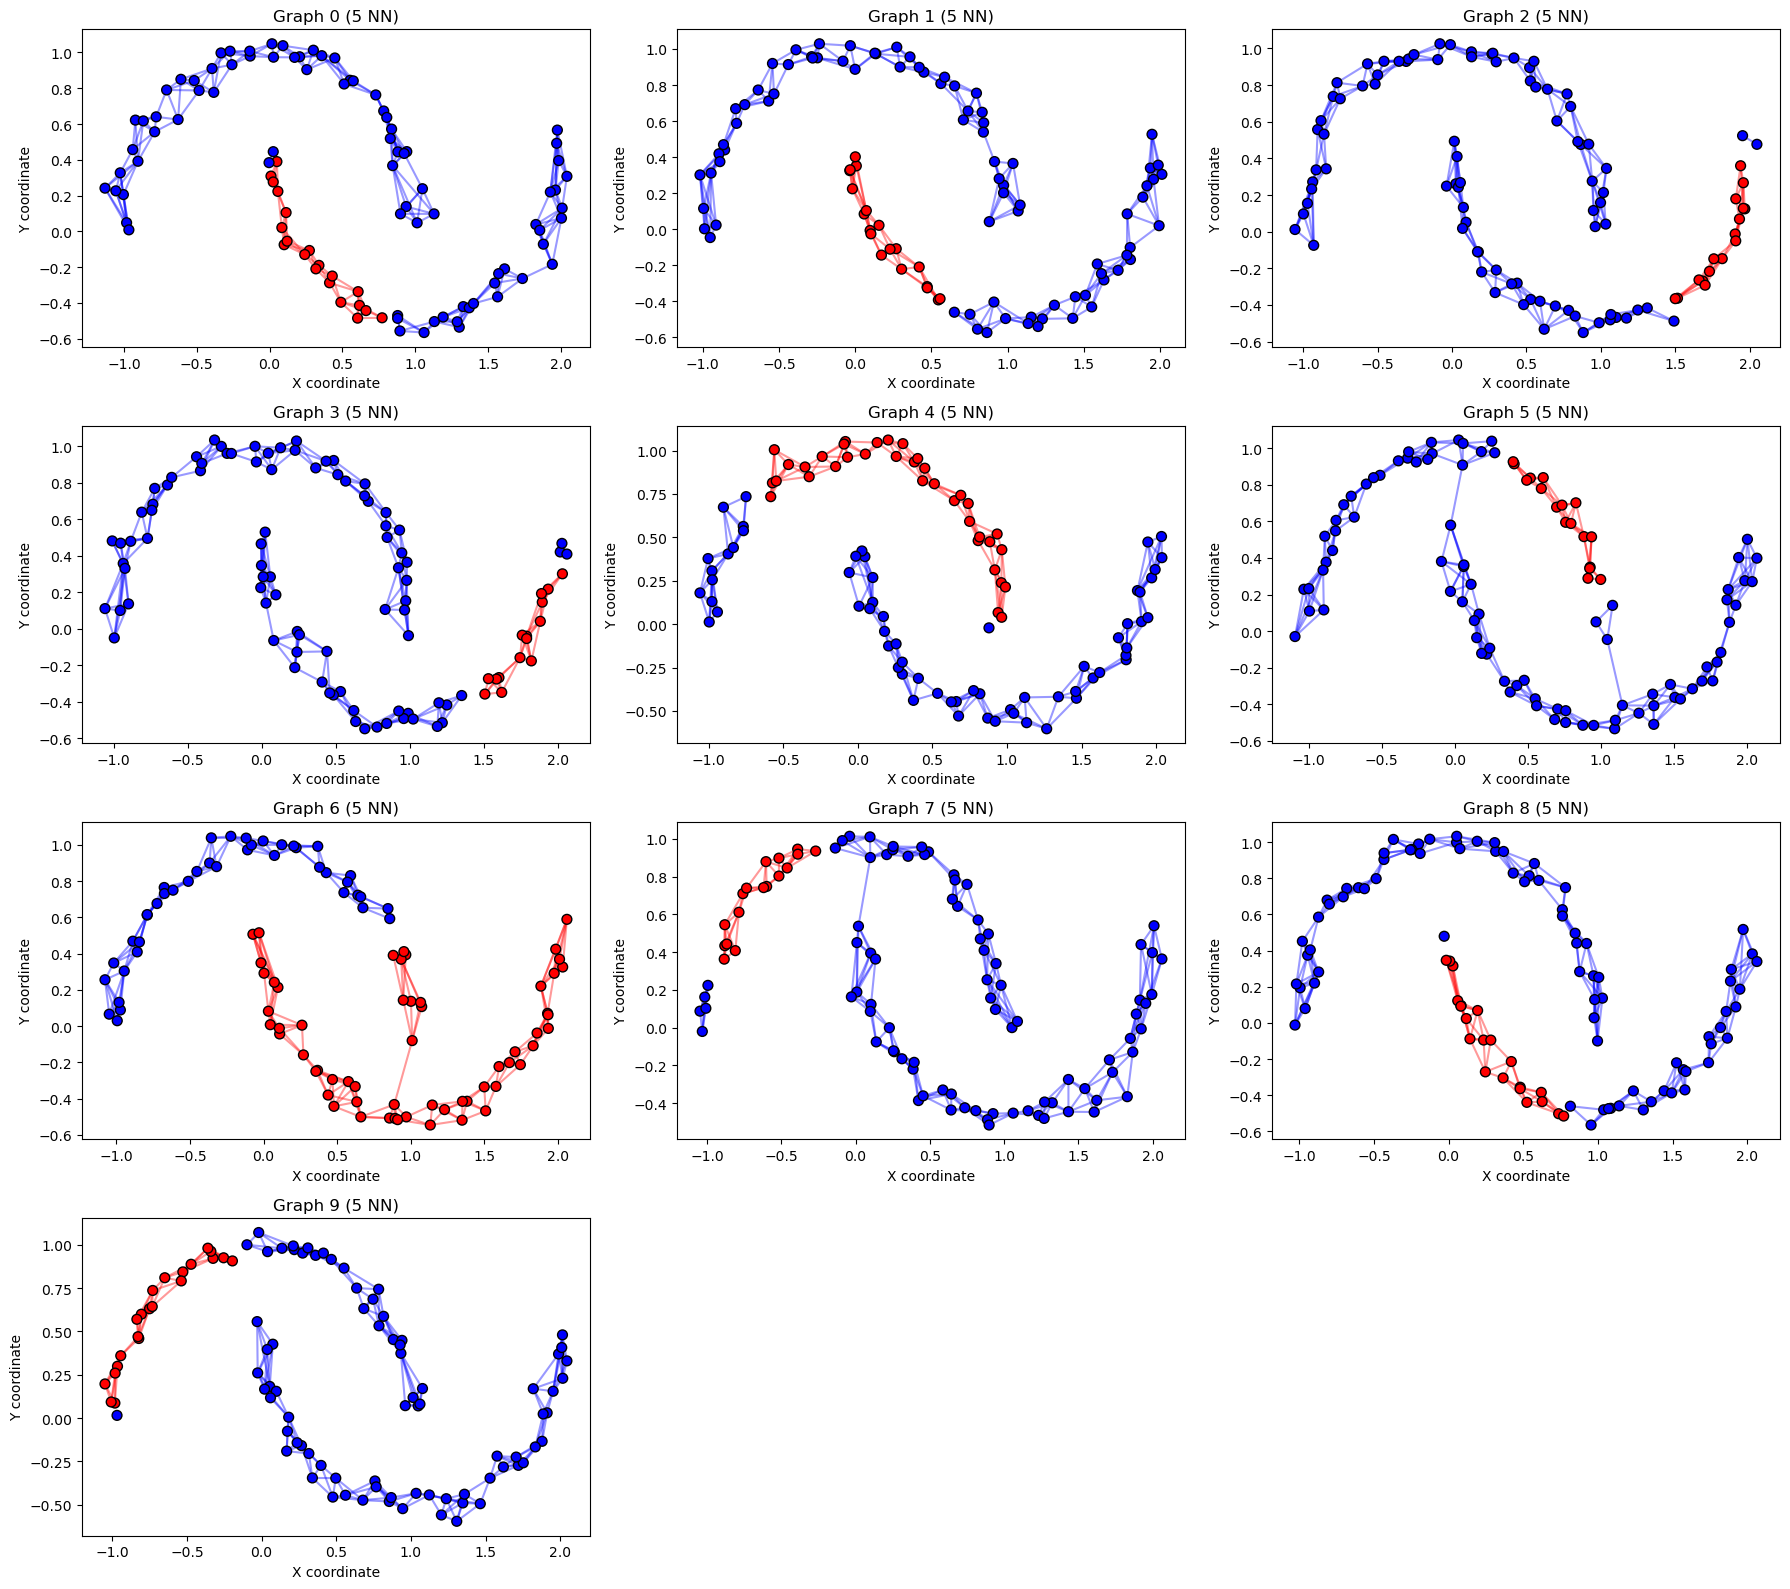

In [287]:
plot_clusters_multi(single_view_graph_X, single_view_graph)

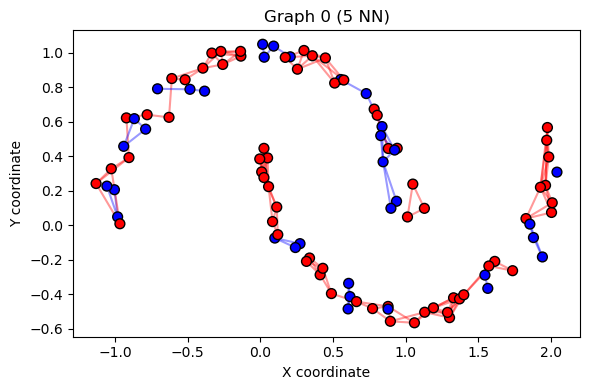

In [288]:
plot_clusters_multi([single_view_graph_X[0]], [global_graph]) # 6 and 8